In [1]:
# Import library
from numpy import loadtxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = MinMaxScaler()

from xgboost import XGBClassifier

from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit,GridSearchCV,\
    cross_val_score, cross_val_predict, ShuffleSplit,learning_curve, train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc,fbeta_score,\
    make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# Load the data
subj_cond = pd.read_table('../Build_DB/subj_cond3.txt', delimiter=",") # unique subjects and their condition
df1 = pd.read_table('../Build_DB/dataframe_stress3.txt', delimiter=",") # dataframe stress
# shuffle datasets
df = df1.sample(frac=1, random_state=1).reset_index(drop=False) 

bad_subj = {41, 42,55, 59, 60, 61, 66, 71, 82,87,90,91,97,98,100,114, 115,121,129,130,131,134,136,138, 147,149,
            153, 154,159,163,171, 170, 173,174,
            35,67,69,77,79,83,85,86,139,146,161,166,
            125} # 3rd line:bad sub in control group ph1, subj 125 not stressed

df_good = df[~df['Subject'].isin(bad_subj)]

# data of first stress phase  
ds = df_good[((df_good.S == 0) & (df_good.Condition == 0))|((df_good.S ==1)&(df_good.Condition ==1))] 

# remove outliers of features values    
ds0 = ds[ds.S == 0]
ds1 = ds[ds.S == 1]
ds_droped0 = ds0.mask((ds0 - ds0.mean()).abs() > 3.5 * ds0.std()).dropna()
ds_droped1 = ds1.mask((ds1 - ds1.mean()).abs() > 3.5 * ds1.std()).dropna()
ds_droped = pd.concat([ds_droped0,ds_droped1])
X = ds_droped.iloc[:, 1:-3] # samples
S =  ds_droped['S'] # stress labels, S=1 stress, S= 0 control
Subject =  ds_droped['Subject']
# condition = 1 means stress then control, condition=0 means control then stress
Condition =  ds_droped['Condition'] 

print("Orig DataFrame: {}" .format(df.shape) )
print("\n")
print("first phase DataFrame: {}" .format(ds.shape) )
print("\n")
print("Removed outliers dataframe: {}".format(ds_droped.shape) )
print("\n")
print("(Samples, Features): {}".format(X.shape) )

Orig DataFrame: (1983, 70)


first phase DataFrame: (546, 70)


Removed outliers dataframe: (415, 70)


(Samples, Features): (415, 66)


In [2]:
modelxgb = XGBClassifier()
good_subj = Subject.unique()
good_subj.sort()
logo = LeaveOneGroupOut()
number_groups = logo.get_n_splits(X, S, Subject)

In [3]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.33, n_splits=2, random_state = 14).split(X, S, groups=Subject))
X_train, X_test = X.iloc[train_inds,:], X.iloc[test_inds,:]
y_train, y_test = S.iloc[train_inds], S.iloc[test_inds]
print(' shape training set: {}' .format(X_train.shape))
print(' shape test set: {}' .format(X_test.shape))
dtr = pd.DataFrame(X_train, y_train) # training data frame
dts = pd.DataFrame(X_test, y_test) # test dataframe
print('check balance in train samples: {}' .format(dtr.groupby('S').size()))
print('check balance in test samples: {}' .format(dts.groupby('S').size()))
train_subject = Subject.iloc[train_inds].unique()
test_subject = Subject.iloc[test_inds].unique()
train_subjects = Subject.iloc[train_inds]
test_subjects = Subject.iloc[test_inds]
print('number subject train: {}' .format(train_subject.shape))
print('number subject test: {}' .format(test_subject.shape))

subj_cond_tr = subj_cond[subj_cond['sub'].isin(train_subject)]
subj_cond_ts = subj_cond[subj_cond['sub'].isin(test_subject)]
print('check balance in train subjects: {}' .format(subj_cond_tr.groupby('cond').size()))
print('check balance in test subjects: {}' .format(subj_cond_ts.groupby('cond').size()))

 shape training set: (282, 66)
 shape test set: (133, 66)
check balance in train samples: S
0    153
1    129
dtype: int64
check balance in test samples: S
0    95
1    38
dtype: int64
number subject train: (40,)
number subject test: (20,)
check balance in train subjects: cond
0    23
1    17
dtype: int64
check balance in test subjects: cond
0    14
1     6
dtype: int64


In [4]:
cv = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
final_features = []
final_features.insert(0, ['ECG_RR_mean' ,'ECG_RR_SDNN' ,'ECG_RR_SDSD', 'ECG_RR_L' ,'ECG_RR_L2',
 'ECG_RR_LoT_2', 'ECG_RR_Log10LT_2', 'RSP_RATE_std', 'RSP_Pk', 'RSP_HF',
 'RSP_HF_gaussF1', 'RSP_ecgHF_pF2n' ,'PPG_PP_CSI_modified', 'PPG_PRT_SDNN',
 'SCL_mean', 'SCL_std'])

final_features.insert(1,['ECG_RR_mean', 'ECG_RR_SDNN', 'ECG_RR_SDSD', 'ECG_RR_LoT_2', 
      'ECG_RR_Log10LT_2', 'RSP_RATE_std', 'RSP_Pk', 'RSP_HF', 
      'RSP_HF_gaussF1', 'RSP_ecgHF_pF2n', 'SCL_mean', 'SCL_std'])

final_features.insert(2,['ECG_RR_mean', 'ECG_RR_SDSD', 'ECG_RR_PNN50', 'ECG_RR_L', 'ECG_RR_CVI',
 'ECG_RR_LoT_2', 'SCL_mean', 'SCL_gradient'])

final_features.insert(3,['ECG_RR_mean'])

final_features.insert(4,['SCL_mean'])

In [5]:
from imblearn.metrics import geometric_mean_score, sensitivity_score,specificity_score
max_depths = np.array([6,3,5,1,6])
max_trees = np.array([41,69,1,1,1])
step_plusone = 5
for j in range(step_plusone):
    print(j)
    feat_list = final_features[j]
    X_tr = X_train[feat_list]
    params = {
    'max_depth': max_depths[j], 
    'n_estimators': max_trees[j]
     }
    modelxgbb = XGBClassifier(**params).fit(X_tr, y_train)
    f1s = []
    ps =[]
    rs =[]
    probs= []
    accs = []
    gms =[]
    spes =[]
    sens = []
    for i, (train_index, val_index) in enumerate(cv.split(X_tr, y_train, train_subjects)):
        X_train_tr, X_val = X_tr.iloc[train_index,:], X_tr.iloc[val_index,:]
        y_train_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        modelxgbb.fit(X_train_tr, y_train_tr)
        # y_proba = modelxgbb.predict_proba(X_val)[:, 1]
        y_proba = modelxgbb.predict_proba(X_val)
        maxInRows = np.amax(y_proba, axis=1)
        prob = np.mean(maxInRows, axis = 0)
        y_pred = modelxgbb.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        f1 = fbeta_score(y_val, y_pred, beta=1)
        p = precision_score(y_val, y_pred)
        r = recall_score(y_val, y_pred)
        
        gm = geometric_mean_score(y_val, y_pred)
        spe = specificity_score(y_val, y_pred)
        sen = sensitivity_score(y_val, y_pred)
    
        probs.append(prob)
        accs.append(acc)
        f1s.append(f1)
        ps.append(p)
        rs.append(r)
        gms.append(gm)
        spes.append(spe)
        sens.append(sen)
    mean_f1 = np.mean(f1s, axis =0)
    mean_p = np.mean(ps, axis =0)
    mean_r = np.mean(rs, axis =0)
    mean_prob = np.mean(probs, axis =0)
    mean_acc = np.mean(accs, axis =0)
    mean_gm = np.mean(gms, axis =0)
    mean_spe = np.mean(spes, axis =0)
    mean_sen = np.mean(sens, axis =0)

    print('Tuned CV Probability: ',mean_prob)
    print('Tuned CV Accuracy: ',mean_acc)
    print('Tuned CV F1: ',mean_f1)
    print('Tuned CV Precision: ',mean_p)
    print('Tuned CV Recall: ',mean_r)
    
    print('Tuned CV Gmean: ',mean_gm)
    print('Tuned CV Specificity: ',mean_spe)
    print('Tuned CV Sensitivity: ',mean_sen)
    print("\n")
    print("\n")

0
Tuned CV Probability:  0.94347525
Tuned CV Accuracy:  0.909324710381861
Tuned CV F1:  0.8780421665030136
Tuned CV Precision:  0.8973576781548918
Tuned CV Recall:  0.8791318681318682
Tuned CV Gmean:  0.9065584142932632
Tuned CV Specificity:  0.9438056763791959
Tuned CV Sensitivity:  0.8791318681318682




1
Tuned CV Probability:  0.954559
Tuned CV Accuracy:  0.9059979581823192
Tuned CV F1:  0.8747450389888402
Tuned CV Precision:  0.8880770376704124
Tuned CV Recall:  0.882978021978022
Tuned CV Gmean:  0.9051538194547811
Tuned CV Specificity:  0.9367590381509675
Tuned CV Sensitivity:  0.882978021978022




2
Tuned CV Probability:  0.62257576
Tuned CV Accuracy:  0.8948693996654924
Tuned CV F1:  0.8639252115663746
Tuned CV Precision:  0.8945992432060542
Tuned CV Recall:  0.8501707717569786
Tuned CV Gmean:  0.8912063812236003
Tuned CV Specificity:  0.9418451569387034
Tuned CV Sensitivity:  0.8501707717569786




3
Tuned CV Probability:  0.60459614
Tuned CV Accuracy:  0.8879877005402426
Tun

In [6]:
tes_prob = np.ones(step_plusone)
tes_acc = np.ones(step_plusone)
tes_f1 = np.ones(step_plusone)
tes_p = np.ones(step_plusone)
tes_r = np.ones(step_plusone)
tes_gm = np.ones(step_plusone)
tes_spe = np.ones(step_plusone)
tes_sen = np.ones(step_plusone)
for j in range(step_plusone):
    print(j)
    feat_list = final_features[j]
    X_tr = X_train[feat_list]
    X_te = X_test[feat_list]
    params = {
    'max_depth': max_depths[j], 
    'n_estimators': max_trees[j]
     }
    model = XGBClassifier(**params).fit(X_tr, y_train)
    print('Acc training set: {:.4f}'
         .format(model.score(X_tr, y_train)))
    y_proba = model.predict_proba(X_te)
    maxInRows = np.amax(y_proba, axis=1)
    tes_prob[j] = np.mean(maxInRows, axis = 0)
    y_pred = model.predict(X_te)
    tes_acc[j] = accuracy_score(y_test, y_pred)
    tes_f1[j] = fbeta_score(y_test, y_pred, beta=1)
    tes_p[j] = precision_score(y_test, y_pred)
    tes_r[j] = recall_score(y_test, y_pred)
    tes_gm[j] = geometric_mean_score(y_test, y_pred)
    tes_spe[j] = specificity_score(y_test, y_pred)
    tes_sen[j] = sensitivity_score(y_test, y_pred)
    print('test Probability: ',tes_prob[j])
    print('test Accuracy: ',tes_acc[j])
    print('test F1: ',tes_f1[j])
    print('test Precision: ',tes_p[j])
    print('test Recall: ',tes_r[j])
    print('test Gmean: ',tes_gm[j])
    print('test Specificity: ',tes_spe[j])
    print('test Sensitivity: ',tes_sen[j])
    print("\n")
    print("\n")


0
Acc training set: 1.0000
test Probability:  0.949171245098114
test Accuracy:  0.8947368421052632
test F1:  0.8108108108108109
test Precision:  0.8333333333333334
test Recall:  0.7894736842105263
test Gmean:  0.8600070862299048
test Specificity:  0.9368421052631579
test Sensitivity:  0.7894736842105263




1
Acc training set: 1.0000
test Probability:  0.9573954939842224
test Accuracy:  0.8872180451127819
test F1:  0.7945205479452055
test Precision:  0.8285714285714286
test Recall:  0.7631578947368421
test Gmean:  0.8455521561402719
test Specificity:  0.9368421052631579
test Sensitivity:  0.7631578947368421




2
Acc training set: 0.9645
test Probability:  0.6201925873756409
test Accuracy:  0.9097744360902256
test F1:  0.8421052631578947
test Precision:  0.8421052631578947
test Recall:  0.8421052631578947
test Gmean:  0.8882114993570099
test Specificity:  0.9368421052631579
test Sensitivity:  0.8421052631578947




3
Acc training set: 0.8759
test Probability:  0.6048418879508972
test A

In [7]:
fl1 = ['ECG_RR_mean' ,'ECG_RR_SDNN' ,'ECG_RR_SDSD', 'ECG_RR_L' ,'ECG_RR_L2',
 'ECG_RR_LoT_2', 'ECG_RR_Log10LT_2', 'RSP_RATE_std', 'RSP_Pk', 'RSP_HF',
 'RSP_HF_gaussF1', 'RSP_ecgHF_pF2n' ,'PPG_PP_CSI_modified', 'PPG_PRT_SDNN',
 'SCL_mean', 'SCL_std']

fl2= ['ECG_RR_mean', 'ECG_RR_SDNN', 'ECG_RR_SDSD', 'ECG_RR_LoT_2', 
      'ECG_RR_Log10LT_2', 'RSP_RATE_std', 'RSP_Pk', 'RSP_HF', 
      'RSP_HF_gaussF1', 'RSP_ecgHF_pF2n', 'SCL_mean', 'SCL_std']

fl3= ['ECG_RR_mean', 'ECG_RR_SDSD', 'ECG_RR_PNN50', 'ECG_RR_L', 'ECG_RR_CVI',
 'ECG_RR_LoT_2', 'SCL_mean', 'SCL_gradient']

fl4 =['ECG_RR_mean']

fl5 =['SCL_mean']

params1 = {
    'max_depth': 6, #4
    'n_estimators': 41 # 83
     }

params2 = {
    'max_depth': 3, 
    'n_estimators': 69
     }
params3 = {
    'max_depth': 5, 
    'n_estimators': 1
     }
params4 = {
    'max_depth': 1, #1
    'n_estimators': 1 #1
     }
params5 = {
    'max_depth': 1, 
    'n_estimators': 1
     }

In [8]:
X_train5 = X_train[fl5]
X_test5 = X_test[fl5]
modelxgb5 = XGBClassifier(**params5)
X_train4 = X_train[fl4]
X_test4 = X_test[fl4]
modelxgb4 = XGBClassifier(**params4)
X_train3 = X_train[fl3]
X_test3 = X_test[fl3]
modelxgb3 = XGBClassifier(**params3)
X_train2 = X_train[fl2]
X_test2 = X_test[fl2]
modelxgb2 = XGBClassifier(**params2)
X_train1 = X_train[fl1]
X_test1 = X_test[fl1]
modelxgb1 = XGBClassifier(**params1)

In [11]:
pred_probs = []
f1s = []
ps =[]
rs =[]
accs = []
p_5s =[]
p_3s =[]
p_2s =[]
pps = []
gms =[]
spes =[]
es =[]
thresholds = np.linspace(0.03, 0.99, 60)
for i, (train_index, val_index) in enumerate(cv.split(X_train5, y_train, train_subjects)):
    X_train_tr5, X_val5 = X_train5.iloc[train_index,:], X_train5.iloc[val_index,:]
    X_train_tr4, X_val4 = X_train4.iloc[train_index,:], X_train4.iloc[val_index,:]
    X_train_tr3, X_val3 = X_train3.iloc[train_index,:], X_train3.iloc[val_index,:]
    X_train_tr2, X_val2 = X_train2.iloc[train_index,:], X_train2.iloc[val_index,:]
    X_train_tr1, X_val1 = X_train1.iloc[train_index,:], X_train1.iloc[val_index,:]
    y_train_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    train_subject_tr = train_subjects.iloc[train_index].unique()
    val_subject= train_subjects.iloc[val_index].unique()
    # print('val subjects: ',val_subject)
    val_subjects= Subject.iloc[val_index]
    modelxgb5.fit(X_train_tr5, y_train_tr)
    modelxgb4.fit(X_train_tr4, y_train_tr)
    modelxgb3.fit(X_train_tr3, y_train_tr)
    modelxgb2.fit(X_train_tr2, y_train_tr)
    modelxgb1.fit(X_train_tr1, y_train_tr)
    pred_prob = np.ones(len(thresholds))
    f1 = np.ones(len(thresholds))
    acc = np.ones(len(thresholds))
    p = np.ones(len(thresholds))
    r = np.ones(len(thresholds))
    gm = np.ones(len(thresholds))
    spe = np.ones(len(thresholds))
    e = np.ones(len(thresholds))
    p_5_percent = np.ones(len(thresholds))
    p_3_percent = np.ones(len(thresholds))
    p_2_percent = np.ones(len(thresholds))
    p_percent = np.ones(len(thresholds))
    n = len(y_val)
    for jj in range(len(thresholds)):
        th = thresholds[jj] 
        p_2 = 0
        p_3 = 0
        p_5 = 0
        y_pred = []
        pred_proba = []
        y_val2 = []
        for vsub in val_subject:
            ind_vsub = train_subjects.index[train_subjects == vsub].tolist()
            # print('subject',vsub)
            # print(ind_vsub)
            X_vsub2, y_vsub = X_val2.loc[ind_vsub,:], y_val.loc[ind_vsub]
            X_vsub3, X_vsub5 = X_val3.loc[ind_vsub,:], X_val5.loc[ind_vsub,:]
            proba_xgb5 = modelxgb5.predict_proba(X_vsub5)[:, 1]
            pred_proba5 = modelxgb5.predict_proba(X_vsub5)
            maxInRows5 = np.amax(pred_proba5, axis=1)
            pred_xgb5 = modelxgb5.predict(X_vsub5)
            proba_xgb3 = modelxgb3.predict_proba(X_vsub3)[:, 1]
            pred_proba3 = modelxgb3.predict_proba(X_vsub3)
            maxInRows3 = np.amax(pred_proba3, axis=1)
            pred_xgb3 = modelxgb3.predict(X_vsub3)
            proba_xgb2 = modelxgb2.predict_proba(X_vsub2)[:, 1]
            pred_proba2 = modelxgb2.predict_proba(X_vsub2)
            maxInRows2 = np.amax(pred_proba2, axis=1)
            pred_xgb2 = modelxgb2.predict(X_vsub2)
            y_pred_adj = np.ones(len(proba_xgb5))
            pred_proba_adj = np.ones(len(proba_xgb5))
            
            y_pred_adj[0] = pred_xgb2[0]
            pred_proba_adj[0] = maxInRows2[0]
            p_2 = p_2 + 1   
            # y_pred_adj[0] = pred_xgb3[0]
            # pred_proba_adj[0] = maxInRows3[0]
            # p_3 = p_3 + 1
            
            for i in range(len(proba_xgb5)): 
                lp = len(proba_xgb5)-1
                if i == lp: break
                # if proba_xgb5[i] > th or proba_xgb5[i] <= 1-th:
                #     y_pred_adj[i+1] = pred_xgb5[i+1]
                #     pred_proba_adj[i+1] = maxInRows5[i+1]
                #     p_5 = p_5 + 1
                # else:
                #     y_pred_adj[i+1] = pred_xgb3[i+1]
                #     pred_proba_adj[i+1] = maxInRows3[i+1]
                #     p_3 = p_3 + 1
                if proba_xgb5[i] > 0.6 or proba_xgb5[i] <= 1-0.6:
                    y_pred_adj[i+1] = pred_xgb5[i+1]
                    pred_proba_adj[i+1] = maxInRows5[i+1]
                    p_5 = p_5 + 1
                elif proba_xgb3[i] > th or proba_xgb3[i] <= 1-th:
                    y_pred_adj[i+1] = pred_xgb3[i+1]
                    pred_proba_adj[i+1] = maxInRows3[i+1]
                    p_3 = p_3 + 1
                else:
                    y_pred_adj[i+1] = pred_xgb2[i+1]
                    pred_proba_adj[i+1] = maxInRows2[i+1]
                    p_2 = p_2 + 1
            y_pred.extend(y_pred_adj)
            pred_proba.extend(pred_proba_adj)
            y_val2.extend(y_vsub)

        p_5_percent[jj] = p_5/n
        p_3_percent[jj] = p_3/n
        p_2_percent[jj] = p_2/n
        p_percent[jj]= 1-(p_2/n)
        # p_percent[jj]= 1-(p_5/n)
        # y_pred_adj = adjusted_classes(proba_xgb, t=th)
        pred_prob[jj] = np.mean(pred_proba, axis = 0)
        acc[jj] = accuracy_score(y_val2, y_pred)
        f1[jj] = fbeta_score(y_val2, y_pred, beta=1)
        p[jj] = precision_score(y_val2, y_pred)
        r[jj] = recall_score(y_val2, y_pred)
        gm[jj] = geometric_mean_score(y_val2, y_pred)
        spe[jj] = specificity_score(y_val2, y_pred)
        # y_pred_adj4 = adjusted_classes(proba_xgb4, t=th)
        # y_pred_adj1 = adjusted_classes(proba_xgb1, t=th)
        # acc5[jj] = accuracy_score(y_val2, pred_xgb5)
        # acc1[jj] = accuracy_score(y_val, y_pred_adj1)
        # acc3[jj] = accuracy_score(y_val, pred_xgb3)
        # e[jj] = 3.86 +p_3_percent[jj]*4.859
        e[jj] = 3.86 +p_3_percent[jj]*4.859+p_2_percent[jj]*13.39553

    pred_probs.append(pred_prob)
    f1s.append(f1)
    ps.append(p)
    rs.append(r)
    accs.append(acc)
    # accs1.append(acc1)
    # accs5.append(acc5)
    p_5s.append(p_5_percent)
    p_3s.append(p_3_percent)
    p_2s.append(p_2_percent)
    pps.append(p_percent)
    gms.append(gm)
    spes.append(spe)
    es.append(e)

mean_pred_prob = np.mean(pred_probs, axis =0)
mean_f1 = np.mean(f1s, axis =0)
mean_p = np.mean(ps, axis =0)
mean_r = np.mean(rs, axis =0)
mean_acc = np.mean(accs, axis =0)
# mean_acc5 = np.mean(accs5, axis =0)
# mean_acc1 = np.mean(accs1, axis =0)
mean_p_5 = np.mean(p_5s, axis =0)
mean_p_3 = np.mean(p_3s, axis =0)
mean_p_2 = np.mean(p_2s, axis =0)
mean_pp = np.mean(pps, axis =0)
mean_gm = np.mean(gms, axis=0)
mean_spe = np.mean(spes, axis=0)
mean_e = np.mean(es, axis=0)

std_pred_prob = np.std(pred_probs, axis =0)
std_f1 = np.std(f1s, axis =0)
std_p = np.std(ps, axis =0)
std_r = np.std(rs, axis =0)
std_acc = np.std(accs, axis =0)
# std_acc1 = np.std(accs1, axis =0)
# std_acc4 = np.std(accs4, axis =0)
std_p_2 = np.std(p_2s, axis =0)
std_pp = np.std(pps, axis =0)
std_gm = np.std(gms, axis =0)
std_spe = np.std(spes, axis =0)
std_e = np.std(es, axis =0)

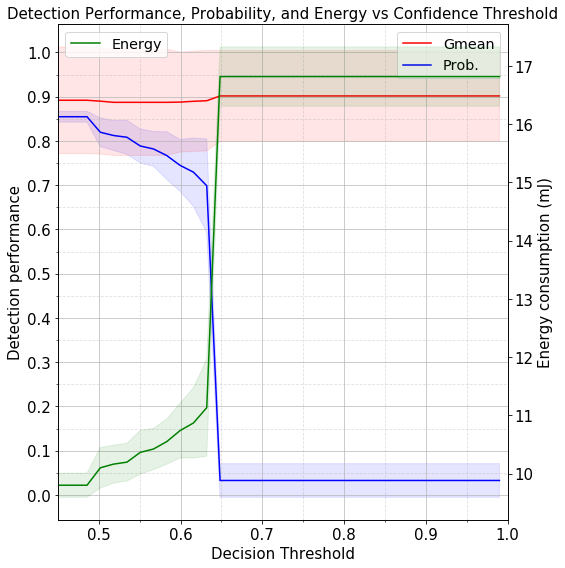

In [12]:
import matplotlib.ticker as mtick
plt.figure(figsize=(8, 8))
plt.xlim(0.45,1)
plt.title("Detection Performance, Probability, and Energy vs Confidence Threshold", fontsize=15)
# plt.plot(thresholds, mean_p, "y--", label="Precision")
# plt.plot(thresholds, mean_r, "m--", label="Recall")
# plt.plot(thresholds, mean_acc, "r-", label="Accuracy")
# plt.plot(thresholds, mean_f1, "y-", label="F1")
plt.plot(thresholds, mean_gm, "r-", label="Gmean")
plt.plot(thresholds, mean_pp, "b-", label="Prob.")
# plt.plot(thresholds, mean_acc3, "g-", label="Acc3")
# plt.plot(thresholds, mean_acc5, "y-", label="Accu5")


plt.ylabel("Detection performance",size = 15)
plt.xlabel("Decision Threshold",size = 15)
major_ticks = np.arange(0, 1.05, 0.1)
minor_ticks = np.arange(0, 1, 0.05)
major_ticksx = np.arange(0.5, 1.05, 0.1)
minor_ticksx = np.arange(0.5, 1, 0.05)
plt.gca().set_yticks(major_ticks)
plt.gca().set_yticks(minor_ticks, minor=True)
plt.gca().set_xticks(major_ticksx)
plt.gca().set_xticks(minor_ticksx, minor=True)
plt.grid(which='major',linestyle='-', alpha=0.8) # which = 'both'
plt.grid(which='minor',linestyle='--', alpha=0.4)
plt.legend(loc='best', fontsize= 'x-large')
plt.fill_between(thresholds, mean_pp - std_pp,mean_pp + std_pp, alpha=0.1, color="b")
# plt.fill_between(thresholds, mean_p - std_p, mean_p + std_p, alpha=0.1, color="b")
# plt.fill_between(thresholds, mean_r - std_r, mean_r + std_r, alpha=0.1, color="g")
plt.fill_between(thresholds, mean_gm - std_gm, mean_gm + std_gm, alpha=0.1, color="r")
plt.xticks(size = 15)
plt.yticks(size = 15)
ax2 = plt.gca().twinx()
ax2.set_ylabel('Energy consumption (mJ)',size = 15)
ax2.plot(thresholds, mean_e, "g-", label="Energy")
ax2.fill_between(thresholds, mean_e - std_e, mean_e + std_e, alpha=0.1, color="g")
ax2.legend(loc='upper left', fontsize= 'x-large')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.tight_layout()
plt.savefig("selfawaress43_2_3_5_Gm.pdf")
plt.savefig("selfawaress43_2_3_5_Gm.png")
plt.show()

In [17]:
print('th: ',thresholds[35])
print('CV Prediction Prob: ',mean_pred_prob[35])
print('CV Accuracy: ',mean_acc[35])
print('CV F1: ',mean_f1[35])
print('CV Precision: ',mean_p[35])
print('CV Recall: ',mean_r[35])
print('CV Gmean: ',mean_gm[35])
print('CV Specificity: ',mean_spe[35])

# print('CV Probaibility 1: ',mean_p_1[35])
print('CV Probaibility 3: ',mean_p_3[35])
print('CV Probaibility 5: ',mean_p_5[35])
print('CV Energy: ',mean_e[35])
print("\n")
print("\n")

th:  0.5994915254237289
CV Prediction Prob:  0.7024928217099421
CV Accuracy:  0.8902382010049704
CV F1:  0.8548120498622035
CV Precision:  0.8796651980630308
CV Recall:  0.8520755336617405
CV Gmean:  0.8877324392804187
CV Specificity:  0.9346419834576931
CV Probaibility 3:  0.711924329853754
CV Probaibility 5:  0.0326966657498768
CV Energy:  10.740177433521087






In [13]:
print('th: ',thresholds[37])
print('CV Prediction Prob: ',mean_pred_prob[37])
print('CV Accuracy: ',mean_acc[37])
print('CV F1: ',mean_f1[37])
print('CV Precision: ',mean_p[37])
print('CV Recall: ',mean_r[37])
print('CV Gmean: ',mean_gm[37])
print('CV Specificity: ',mean_spe[37])

print('CV Probaibility 1: ',mean_p_2[37])
print('CV Probaibility 3: ',mean_p_3[37])
print('CV Probaibility 5: ',mean_p_5[37])
print('CV Energy: ',mean_e[37])
print("\n")
print("\n")

th:  0.6320338983050848
CV Prediction Prob:  0.7156488057103717
CV Accuracy:  0.8937167249009171
CV F1:  0.8588275764836352
CV Precision:  0.8828873583504085
CV Recall:  0.855408866995074
CV Gmean:  0.8908359598481079
CV Specificity:  0.9370810078479372
CV Probaibility 1:  0.3013603774279099
CV Probaibility 3:  0.6659429568222133
CV Probaibility 5:  0.0326966657498768
CV Energy:  11.132698803846026






In [14]:
p_3 = 0
p_5 = 0
pred_prob = []
y_pred = []
y_test3 = []
p_5s = []
p_3s = []
for tsub in test_subject:
    ind_tsub = test_subjects.index[test_subjects == tsub].tolist()
    # print(tsub)
    # print(ind_tsub)
    X_tesub1, y_tesub = X_test1.loc[ind_tsub,:], y_test.loc[ind_tsub]
    X_tesub3, X_tesub5 = X_test3.loc[ind_tsub,:], X_test5.loc[ind_tsub,:]
    proba_xgb5 = modelxgb5.predict_proba(X_tesub5)[:, 1]
    pred_proba5 = modelxgb5.predict_proba(X_tesub5)
    maxInRows5 = np.amax(pred_proba5, axis=1)
    pred_xgb5 = modelxgb5.predict(X_tesub5)
    proba_xgb3 = modelxgb3.predict_proba(X_tesub3)[:, 1]
    pred_proba3 = modelxgb3.predict_proba(X_tesub3)
    maxInRows3 = np.amax(pred_proba3, axis=1)
    pred_xgb3 = modelxgb3.predict(X_tesub3)
    proba_xgb1 = modelxgb1.predict_proba(X_tesub1)[:, 1]
    pred_proba1 = modelxgb1.predict_proba(X_tesub1)
    maxInRows1 = np.amax(pred_proba1, axis=1)
    pred_xgb1 = modelxgb1.predict(X_tesub1)
    y_pred_adj = np.ones(len(proba_xgb5))
    pred_proba_adj = np.ones(len(proba_xgb5))
    # y_pred_adj[0] = pred_xgb3[0]
    # p_1 = p_1 + 1
    y_pred_adj[0] = pred_xgb3[0]
    pred_proba_adj[0] = maxInRows3[0]
    p_3 = p_3 + 1

    for i in range(len(proba_xgb5)): 
        lp = len(proba_xgb5)-1
        if i == lp: break
        if proba_xgb5[i] > 0.6 or proba_xgb5[i] <= 1-0.6:
            y_pred_adj[i+1] = pred_xgb5[i+1]
            pred_proba_adj[i+1] = maxInRows5[i+1]
            p_5 = p_5 + 1
        else:
            y_pred_adj[i+1] = pred_xgb3[i+1]
            pred_proba_adj[i+1] = maxInRows3[i+1]
            p_3 = p_3 +1
                
    y_test3.extend(y_tesub)
    y_pred.extend(y_pred_adj)
    pred_prob.extend(pred_proba_adj) 
    p_5s.append(p_5)
    p_3s.append(p_3)
    
n = len(y_test)
p_3_percent = p_3/n
p_5_percent = p_5/n

pred_prob_test = np.mean(pred_prob, axis=0)
acc = accuracy_score(y_test3, y_pred)
f1 = fbeta_score(y_test3, y_pred, beta=1)
p = precision_score(y_test3, y_pred)
r = recall_score(y_test3, y_pred)
gm = geometric_mean_score(y_test3, y_pred)
spe = specificity_score(y_test3, y_pred)
e = 3.86 +p_3_percent*4.859

print('test Prediction Probability: ',pred_prob_test)
print('test Accuracy: ',acc)
print('test F1: ',f1)
print('test Precision: ',p)
print('test Recall: ',r)
print('test Gmean: ',gm)
print('test Specificity: ',spe)

print('test Probaibility 3: ',p_3_percent)
print('test Probaibility 5: ',p_5_percent)
print('test Energy: ',e)
print("\n")
print("\n")

test Prediction Probability:  0.6141760909467712
test Accuracy:  0.8872180451127819
test F1:  0.8051948051948051
test Precision:  0.7948717948717948
test Recall:  0.8157894736842105
test Gmean:  0.8643444988789957
test Specificity:  0.9157894736842105
test Probaibility 3:  0.8796992481203008
test Probaibility 5:  0.12030075187969924
test Energy:  8.134458646616542






In [16]:
p_3 = 0
p_2 = 0
p_5 = 0
pred_prob = []
y_pred = []
y_test2 = []
p_2s = []
p_5s = []
p_3s = []
for tsub in test_subject:
    ind_tsub = test_subjects.index[test_subjects == tsub].tolist()
    print(tsub)
    print(ind_tsub)
    X_tesub2, y_tesub = X_test2.loc[ind_tsub,:], y_test.loc[ind_tsub]
    X_tesub3, X_tesub5 = X_test3.loc[ind_tsub,:], X_test5.loc[ind_tsub,:]
    proba_xgb5 = modelxgb5.predict_proba(X_tesub5)[:, 1]
    pred_proba5 = modelxgb5.predict_proba(X_tesub5)
    maxInRows5 = np.amax(pred_proba5, axis=1)
    pred_xgb5 = modelxgb5.predict(X_tesub5)
    proba_xgb3 = modelxgb3.predict_proba(X_tesub3)[:, 1]
    pred_proba3 = modelxgb3.predict_proba(X_tesub3)
    maxInRows3 = np.amax(pred_proba3, axis=1)
    pred_xgb3 = modelxgb3.predict(X_tesub3)
    proba_xgb2 = modelxgb2.predict_proba(X_tesub2)[:, 1]
    pred_proba2 = modelxgb2.predict_proba(X_tesub2)
    maxInRows2 = np.amax(pred_proba2, axis=1)
    pred_xgb2 = modelxgb2.predict(X_tesub2)
    y_pred_adj = np.ones(len(proba_xgb5))
    pred_proba_adj = np.ones(len(proba_xgb5))
    
    m = 2*np.ones(len(proba_xgb5))
    m[0] = 3
    y_pred_adj[0] = pred_xgb2[0]
    pred_proba_adj[0] = maxInRows2[0]
    p_1 = p_2 + 1
    
    # m[0] = 5
    # y_pred_adj[0] = pred_xgb5[0]
    # p_5 = p_5 + 1
    
    for i in range(len(proba_xgb5)): 
        lp = len(proba_xgb5)-1
        if i == lp: break
        if m[i] ==5:
            if proba_xgb5[i] > 0.6 or proba_xgb5[i] <= 1-0.6:
                y_pred_adj[i+1] = pred_xgb5[i+1]
                pred_proba_adj[i+1] = maxInRows5[i+1]
                p_5 = p_5 + 1
                m[i+1] = 5
            else:
                y_pred_adj[i+1] = pred_xgb3[i+1]
                pred_proba_adj[i+1] = maxInRows3[i+1]
                p_3 = p_3 +1
                m[i+1] = 3
                
        if m[i] ==3:
            if proba_xgb5[i] > 0.6 or proba_xgb5[i] <= 1-0.6:
                y_pred_adj[i+1] = pred_xgb5[i+1]
                pred_proba_adj[i+1] = maxInRows5[i+1]
                p_5 = p_5 + 1
                m[i+1] = 5
            elif proba_xgb3[i] > 0.63 or proba_xgb3[i] <= 1-0.63:
                y_pred_adj[i+1] = pred_xgb3[i+1]
                pred_proba_adj[i+1] = maxInRows3[i+1]
                p_3 = p_3 +1
                m[i+1] = 3
            else:
                y_pred_adj[i+1] = pred_xgb2[i+1]
                pred_proba_adj[i+1] = maxInRows2[i+1]
                p_2 = p_2 + 1
                m[i+1] = 3 
                
    y_pred.extend(y_pred_adj)
    y_test2.extend(y_tesub)
    pred_prob.extend(pred_proba_adj)
    p_5s.append(p_5)
    p_3s.append(p_3)
    p_2s.append(p_2)
    
p_3_percent = p_3/n
p_5_percent = p_5/n
p_2_percent = p_2/n

pred_prob_test = np.mean(pred_prob, axis=0)
acc = accuracy_score(y_test2, y_pred)
f1 = fbeta_score(y_test2, y_pred, beta=1)
p = precision_score(y_test2, y_pred)
r = recall_score(y_test2, y_pred)
gm = geometric_mean_score(y_test2, y_pred)
spe = specificity_score(y_test2, y_pred)
e = 3.86 +p_3_percent*4.859+p_2_percent*13.39553

print('test Prediction Probability: ',pred_prob_test)
print('test Accuracy: ',acc)
print('test F1: ',f1)
print('test Precision: ',p)
print('test Recall: ',r)
print('test Gmean: ',gm)
print('test Specificity: ',spe)
print('test Probaibility 2: ',p_2_percent)
print('test Probaibility 3: ',p_3_percent)
print('test Probaibility 5: ',p_5_percent)
print('test Energy: ',e)
print("\n")
print("\n")

119
[4, 450, 1020, 1161]
137
[31, 327, 516, 985, 1547, 1646, 1653, 1911]
128
[49, 970, 1001, 1497, 1735, 1926]
63
[54, 491, 1088, 1184, 1275, 1413]
94
[111, 251, 354, 407, 463, 692, 1016, 1074]
162
[131, 169, 276, 334, 433, 1218, 1484]
70
[144, 320, 554, 621, 701, 1007, 1136, 1418, 1681]
148
[205, 634, 1772, 1867]
151
[244, 556, 805, 868, 876, 914, 1453, 1726]
120
[291, 666, 669, 758, 1138, 1505, 1820]
169
[367, 543, 864, 1186, 1323, 1404, 1690, 1843]
132
[388, 414, 654, 829, 1190, 1952]
156
[671, 750, 819, 1108, 1556, 1557, 1762]
103
[1124, 1254, 1346, 1414, 1454, 1498, 1612]
124
[57, 216, 385, 455, 485, 557, 1018]
158
[105, 383, 1860, 1881]
127
[270, 409, 1079, 1458, 1490, 1837, 1948]
167
[355, 394, 708, 1060, 1101, 1307, 1355, 1356, 1583]
47
[605, 1271, 1383, 1621]
152
[699, 706, 1023, 1302, 1504, 1685, 1869]
test Prediction Probability:  0.725849321462158
test Accuracy:  0.8872180451127819
test F1:  0.7945205479452055
test Precision:  0.8285714285714286
test Recall:  0.763157894736

c:\users\niloo\desktop\project2019_20\venv3701\lib\site-packages\ipykernel_launcher.py:29: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
c:\users\niloo\desktop\project2019_20\venv3701\lib\site-packages\ipykernel_launcher.py:30: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


<Figure size 1600x1000 with 0 Axes>

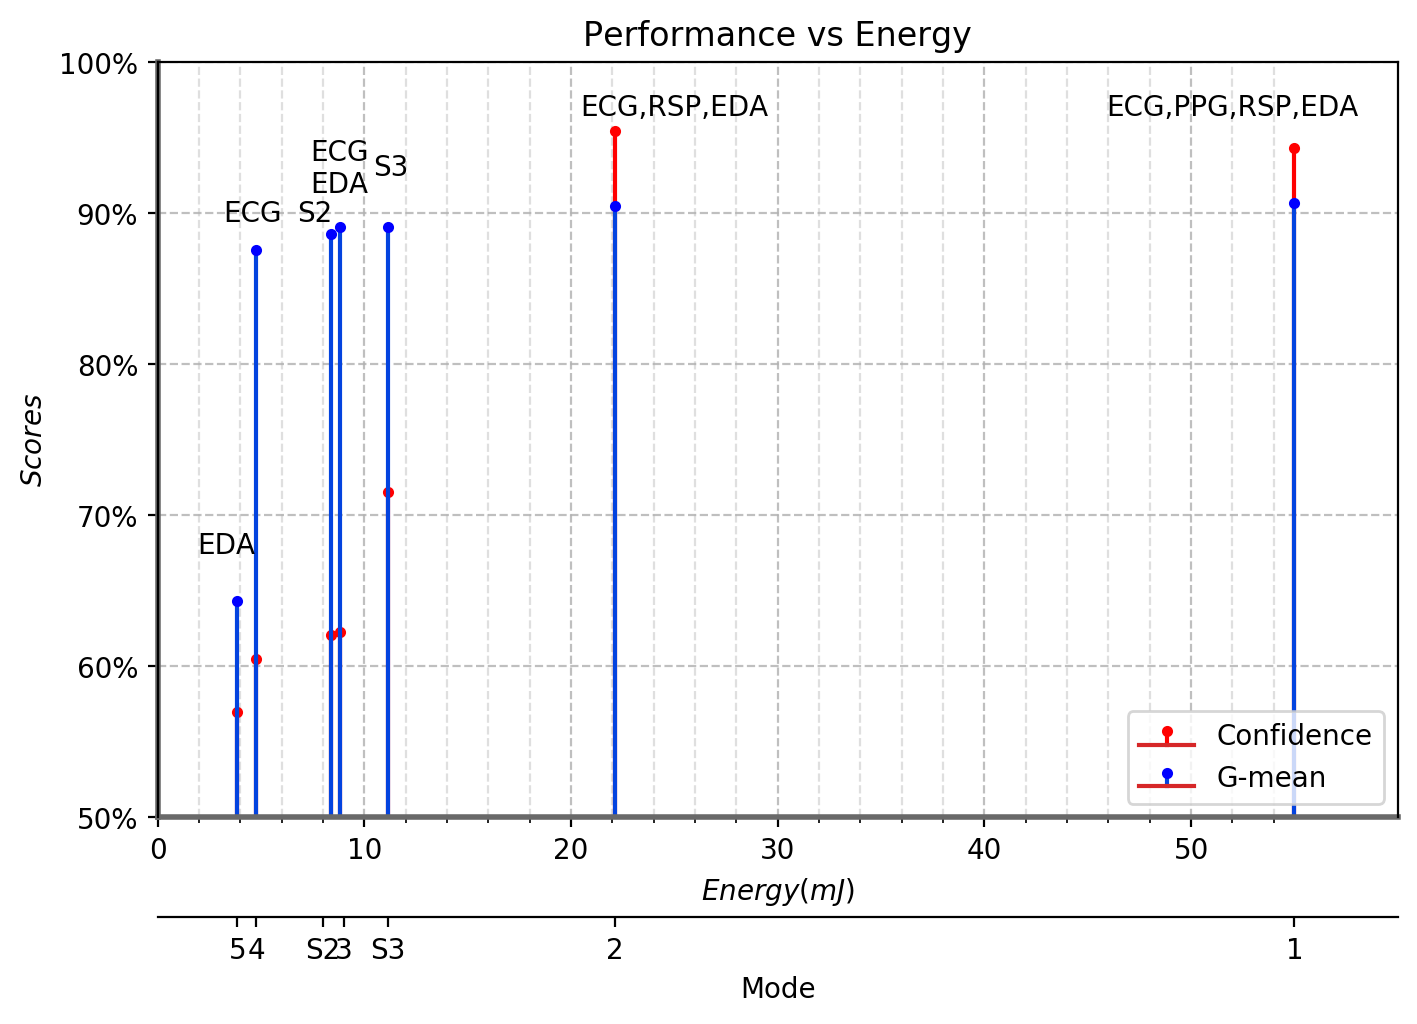

In [21]:
import matplotlib.ticker as mtick

# plt.figure(figsize=(6,4), dpi= 100)
plt.figure(figsize=(8,5), dpi= 200)
# eng = [55.00, 29.72, 22.12, 8.8, 8.4, 4.78, 3.86] # cv
eng = [55.00, 22.12, 11.13, 8.8, 8.4, 4.78, 3.86] 

plt.figure(figsize=(8,5), dpi= 200)

plt.title('Performance vs Energy', fontdict={'size':12})
plt.xlim(0,60)
plt.ylim(bottom =0.5, top=1) # before 0.4
#plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('$Energy (mJ)$')
plt.ylabel('$Scores$')
# Major ticks every 10, minor ticks every 2
major_ticks = np.arange(0, 55, 10)
minor_ticks = np.arange(0, 55, 2)

plt.gca().set_xticks(major_ticks)
plt.gca().set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)
# test_acc = [0.89473684, 0.85714286, 0.9023, 0.90977444, 0.9098, 0.82706767, 0.63909774]
# test_gm = [0.86000709, 0.81672273, 0.8549, 0.8882115, 0.8882, 0.77780856, 0.61016323]
cv_prob = [0.9435, 0.9546, 0.7156,  0.6226, 0.6207, 0.6046, 0.5695]
cv_gm = [0.9066, 0.9051, 0.8908,  0.8912, 0.8861,0.8756, 0.6433]

plt.stem(eng, cv_prob,label="Confidence",markerfmt ="r.",linefmt='r')# ,linefmt='green'
plt.stem(eng, cv_gm,label="G-mean",markerfmt ="b.",linefmt='xkcd:blue')

plt.text(52,0.97,'ECG,PPG,RSP,EDA', ha = 'center', va = 'center')
plt.text(25,0.97,'ECG,RSP,EDA', ha = 'center', va = 'center')
plt.text(11.3,0.93,'S3', ha = 'center', va = 'center')

plt.text(8.8,0.94,'ECG', ha = 'center', va = 'center')
plt.text(8.8,0.9188,'EDA', ha = 'center', va = 'center')

plt.text(7.6,0.90,'S2', ha = 'center', va = 'center')
plt.text(4.6,0.90,'ECG', ha = 'center', va = 'center')
plt.text(3.3,0.68,'EDA', ha = 'center', va = 'center')

plt.legend(loc='lower right')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["left"].set_color("dimgray")
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["bottom"].set_color("dimgray")
plt.grid(which='major',linestyle='--', alpha=0.8) # which = 'both'
plt.grid(which='minor',linestyle='--', alpha=0.4)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
#plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
#plt.gca().spines["left"].set_alpha(0.3)   

# Set scond x-axis
ax2 = plt.gca().twiny()

# Decide the ticklabel position in the new x-axis,
# then convert them to the position in the old x-axis
newlabel = [1, 2, 'S3',3,'S2',4,5] # labels of the xticklabels: the position in the new x-axis
  # position of the xticklabels in the old x-axis
newpos   = [55.00, 22.12, 11.13, 9, 8, 4.78, 3.86] 
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)

ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mode')
ax2.set_xlim(0,60)

plt.savefig("perf_vs_eng_s43_cv.pdf", bbox_inches = 'tight')
plt.savefig("perf_vs_eng_s43_cv.png", bbox_inches = 'tight')
plt.show()



Setting feature_perturbation = "tree_path_dependent" because no background data was given.


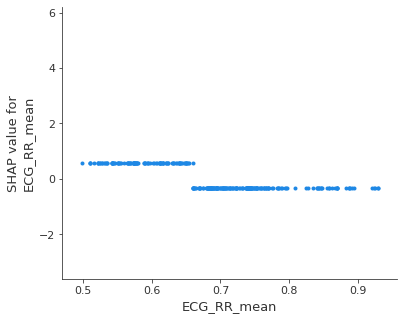

In [46]:
import shap
feat_list = final_features[3]
x = X_train[feat_list]
xt = X_test[feat_list]
paramss = {
    'max_depth': 1, 
    'n_estimators': 1
     }
model = XGBClassifier(**paramss).fit(x, y_train)
# modelxgb.fit(X_train, y_train)
shap_values = shap.TreeExplainer(model).shap_values(x)
#shap.summary_plot(shap_values, X_train)
shap.dependence_plot("ECG_RR_mean", shap_values, x, interaction_index=None ,show=False)
plt.ylim(bottom =-3.6, top=6.2)
# shap.dependence_plot("SCL_mean", shap_values, x, interaction_index="ECG_RR_mean" ,show=False)
plt.savefig("shap_mode4new_ecg_ylim2.png", bbox_inches = 'tight')
plt.savefig("shap_mode4new_ecg_ylim2.pdf", bbox_inches = 'tight')
# shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=16,show=False)
plt.show()

